In [1]:
#!pip install torchmetrics

In [2]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
#metricas
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import pyiqa


from model.tranfAdvModel import SRTransG
from model.discriminatorVITModel import ViTDiscriminator
from model.dataset_manager import load_dataset

#from metrics.imageMetricsSewar import compute_quality_losses,compute_metrics_for_model_dataset
from metrics.imageMetricsTorchMetrics import compute_quality_losses,compute_metrics_for_model_dataset

from collections import Counter
import pickle
import time
import random

In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# 1. Configuración
# ──────────────────────────────────────────────────────────────────────────────
dataset_dir    = "G:/MaestriaInformatica/Tesis/Datasets/"
output_dir= "G:/MaestriaInformatica/Tesis/Outputs_Multilayer/TransfAdv_Sat/"
sample_test_output_dir = os.path.join(output_dir, "samples/")

model_save_dir = os.path.join(output_dir, "models/")

hr_train_dir = os.path.join(dataset_dir,"SatImages/perusat_v5/HR/")
lr_train_dir = os.path.join(dataset_dir,"SatImages/perusat_v5/LR_BICUBIC/X2/")
suffix       = "_x2"
suffix = "_x2" 
hr_size=(512,512)
max_images = 400
val_frac = 0.20

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# ---------------------------------------------------
# 2. Configuración del DataLoader
# ---------------------------------------------------
# archivo donde está definido el split train-val del dataset
splits_pkl = os.path.join(model_save_dir, "splits.pkl")
#cargamos el dataset
train_dataset, val_dataset, train_hr, val_hr, _ = load_dataset(hr_train_dir, lr_train_dir, suffix=suffix, max_images=max_images, hr_size=hr_size, val_frac=val_frac, pickle_path=splits_pkl)

# Crear DataLoader (batch size pequeño para ahorrar memoria)
batch_size = 30
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

lr_all, hr_all = train_loader.dataset.tensors

print("Dataset HR (CPU):", hr_all.shape)
print("Dataset LR (CPU):", lr_all.shape)

lr_all, hr_all = val_loader.dataset.tensors

print("Dataset HR (CPU):", hr_all.shape)
print("Dataset LR (CPU):", lr_all.shape)

Dataset HR (CPU): torch.Size([320, 4, 512, 512])
Dataset LR (CPU): torch.Size([320, 4, 256, 256])
Dataset HR (CPU): torch.Size([80, 4, 512, 512])
Dataset LR (CPU): torch.Size([80, 4, 256, 256])


In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# 4. Función de evaluación
# ──────────────────────────────────────────────────────────────────────────────
def evaluate_dataset(generator, data_loader, device):
    """
    Evalúa el generador en todo el dataset y calcula el PSNR y SSIM promedio.
    Para el calculo de las métricas se consideran 3 librerias distintas: pyiqa, skiimage y torchmetrics
    
    Args:
        generator (nn.Module): El modelo generador.
        data_loader (DataLoader): DataLoader que proporciona pares (LR, HR).
        device (torch.device): Dispositivo (GPU o CPU) a utilizar.
        
    Returns:
        avg_psnr_pyiqa (float): PSNR promedio en decibelios. Obtenido con la librería pyiqa.
        avg_ssim_pyiqa (float): SSIM promedio. Obtenido con la librería pyiqa.
        avg_psnr_skiimage (float): PSNR promedio en decibelios. Obtenido con la librería skiimage.
        avg_ssim_skiimage (float): SSIM promedio. Obtenido con la librería skiimage.
        avg_psnr_tcm (float): PSNR promedio en decibelios. Obtenido con la librería torchmetrics.
        avg_ssim_tcm (float): SSIM promedio. Obtenido con la librería torchmetrics.
    """
    generator.eval()

    with torch.no_grad():
        per_channel = False   
        metrics_dict = compute_metrics_for_model_dataset(generator, data_loader, 1.0, device, per_channel=per_channel)        
             
        
        if per_channel:
            avg_psnr = metrics_dict["psnr_overall_mean"]
            avg_ssim = metrics_dict["ssim_overall_mean"]
        else:
            avg_psnr = metrics_dict["psnr"]
            avg_ssim = metrics_dict["ssim"]
    
    return avg_psnr, avg_ssim

In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# 5. Iterar sobre checkpoints y recolectar métricas
# ──────────────────────────────────────────────────────────────────────────────
ckpts = sorted([
    fn for fn in os.listdir(model_save_dir)
    if fn.startswith("generator_EP") and fn.endswith(".pth")
])

# Parámetros de tu modelo
gen_kwargs = dict(    
    input_dim = 4,
    embed_dim=32,
    patch_size=16,
    token_dim = 512,
    num_levels=3, 
    num_refinement=1,
    encoder_transformer_blocks=[4,6,6],
    decoder_transformer_blocks=[4,4,6],
    refinement_transformer_blocks=[4]
)

random.seed(5)
sample_indices = random.sample(range(len(val_dataset)), 3)
sample_names   = [val_hr[i] for i in sample_indices] 

os.makedirs(sample_test_output_dir, exist_ok=True)

epochs    = []
#PSNR y SSIM - torchimage
trchimg_psnr_tr   = []
trchimg_ssim_tr   = []
trchimg_psnr_val  = []
trchimg_ssim_val  = []


start_total = time.time()
print(f"Start")
for ckpt in ckpts:
    epoch_start = time.time()
    ep = int(ckpt.split("EP")[1].split(".")[0])
    
    # montar modelo y cargar pesos
    net = SRTransG(**gen_kwargs).to(device)
    net.load_state_dict(torch.load(os.path.join(model_save_dir, ckpt), map_location=device))
        
    # evaluar    
    epochs.append(ep)

    #print(f"Generating metrics")
    psnr_tr,ssim_tr = evaluate_dataset(net, train_loader,device)
    psnr_val,ssim_val = evaluate_dataset(net, val_loader,device)
    #print(f"Finished generating metrics")
    #torchimage    
    trchimg_psnr_tr.append(psnr_tr)
    trchimg_ssim_tr.append(ssim_tr)
    trchimg_psnr_val.append(psnr_val)
    trchimg_ssim_val.append(ssim_val)


    elapsed = time.time() - epoch_start
    mins, secs = divmod(int(elapsed), 60)
    total_elapsed = time.time() - start_total
    t_m, t_s = divmod(int(total_elapsed), 60)
    m, s = divmod(int(elapsed), 60)
    
    print(f"Epoch {ep:02d} Time_Epoch: {mins}m{secs}s, Time_Total: {t_m}m{t_s}s")
    print(f"\tTrain trchimg-PSNR: {psnr_tr:.4f} | trchimg-SSIM: {ssim_tr:.4f}")
    print(f"\tVal trchimg-PSNR: {psnr_val:.4f} | trchimg-SSIM: {ssim_val:.4f}")

    print(f"Generating images")
   
    eps = 1e-6
    
    with torch.no_grad():
        for idx, name in zip(sample_indices, sample_names):
            # --- Extraer y guardar LR ---
            hr = val_dataset[idx][1].unsqueeze(0).to(device)  # (1,4,512,512)
            hr_np = hr[0].cpu().numpy()  # (4,256,256)
            lr = val_dataset[idx][0].unsqueeze(0).to(device)  # (1,4,256,256)
            lr_np = lr[0].cpu().numpy()  # (4,256,256)
    
            # LR RGB composite
            rgb_lr = lr_np[:3, :, :].transpose(1, 2, 0)
            mn, mx = rgb_lr.min(), rgb_lr.max()
            rgb_lr_norm = (rgb_lr - mn) / (mx - mn + eps)
            rgb_lr_uint8 = (rgb_lr_norm * 255).astype(np.uint8)
            out_lr_rgb = f"{sample_test_output_dir}{name}_LR_RGB.png"
            Image.fromarray(rgb_lr_uint8).save(out_lr_rgb)
    
            # LR NIRF grayscale
            nirf_lr = lr_np[3, :, :]
            mn4, mx4 = nirf_lr.min(), nirf_lr.max()
            nirf_lr_norm = (nirf_lr - mn4) / (mx4 - mn4 + eps)
            nirf_lr_uint8 = (nirf_lr_norm * 255).astype(np.uint8)
            out_lr_nirf = f"{sample_test_output_dir}{name}_LR_NIRF.png"
            Image.fromarray(nirf_lr_uint8, mode='L').save(out_lr_nirf)

            # HR RGB composite
            rgb_hr = hr_np[:3, :, :].transpose(1, 2, 0)
            mn, mx = rgb_hr.min(), rgb_hr.max()
            rgb_hr_norm = (rgb_hr - mn) / (mx - mn + eps)
            rgb_hr_uint8 = (rgb_hr_norm * 255).astype(np.uint8)
            out_hr_rgb = f"{sample_test_output_dir}{name}_HR_RGB.png"
            Image.fromarray(rgb_hr_uint8).save(out_hr_rgb)
    
            # HR NIRF grayscale
            nirf_hr = hr_np[3, :, :]
            mn4, mx4 = nirf_hr.min(), nirf_hr.max()
            nirf_hr_norm = (nirf_hr - mn4) / (mx4 - mn4 + eps)
            nirf_hr_uint8 = (nirf_hr_norm * 255).astype(np.uint8)
            out_hr_nirf = f"{sample_test_output_dir}{name}_HR_NIRF.png"
            Image.fromarray(nirf_hr_uint8, mode='L').save(out_hr_nirf)
    
            # --- Generar SR y guardar SR RGB + NIRF ---
            sr_img = net(lr)[0].cpu().numpy()  # (4,H,W), en [-1,1]
    
            # SR RGB composite
            rgb_sr = sr_img[:3, :, :].transpose(1, 2, 0)
            mn, mx = rgb_sr.min(), rgb_sr.max()
            rgb_sr_norm = (rgb_sr - mn) / (mx - mn + eps)
            rgb_sr_uint8 = (rgb_sr_norm * 255).astype(np.uint8)
            out_sr_rgb = f"{sample_test_output_dir}{name}_SR_RGB_EP{ep:02d}.png"
            Image.fromarray(rgb_sr_uint8).save(out_sr_rgb)
    
            # SR NIRF grayscale
            nirf_sr = sr_img[3, :, :]
            mn4, mx4 = nirf_sr.min(), nirf_sr.max()
            nirf_sr_norm = (nirf_sr - mn4) / (mx4 - mn4 + eps)
            nirf_sr_uint8 = (nirf_sr_norm * 255).astype(np.uint8)
            out_sr_nirf = f"{sample_test_output_dir}{name}_SR_NIRF_EP{ep:02d}.png"
            Image.fromarray(nirf_sr_uint8, mode='L').save(out_sr_nirf)
print(f"End")

Start


C:\Users\victo\AppData\Local\Temp\ipykernel_118756\1985024035.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(os.path.join(model_save_dir

Epoch 01 Time_Epoch: 0m9s, Time_Total: 0m9s
	Train trchimg-PSNR: 17.8837 | trchimg-SSIM: 0.4446
	Val trchimg-PSNR: 17.8886 | trchimg-SSIM: 0.4446
Generating images
Epoch 02 Time_Epoch: 0m8s, Time_Total: 0m18s
	Train trchimg-PSNR: 21.6138 | trchimg-SSIM: 0.5957
	Val trchimg-PSNR: 21.6101 | trchimg-SSIM: 0.5953
Generating images
Epoch 03 Time_Epoch: 0m8s, Time_Total: 0m27s
	Train trchimg-PSNR: 23.9269 | trchimg-SSIM: 0.7097
	Val trchimg-PSNR: 23.9104 | trchimg-SSIM: 0.7093
Generating images
Epoch 04 Time_Epoch: 0m8s, Time_Total: 0m37s
	Train trchimg-PSNR: 27.1546 | trchimg-SSIM: 0.8202
	Val trchimg-PSNR: 27.1409 | trchimg-SSIM: 0.8200
Generating images
Epoch 05 Time_Epoch: 0m9s, Time_Total: 0m46s
	Train trchimg-PSNR: 23.7645 | trchimg-SSIM: 0.6943
	Val trchimg-PSNR: 23.7601 | trchimg-SSIM: 0.6944
Generating images
Epoch 06 Time_Epoch: 0m8s, Time_Total: 0m56s
	Train trchimg-PSNR: 25.7901 | trchimg-SSIM: 0.7857
	Val trchimg-PSNR: 25.7807 | trchimg-SSIM: 0.7858
Generating images
Epoch 07 Ti

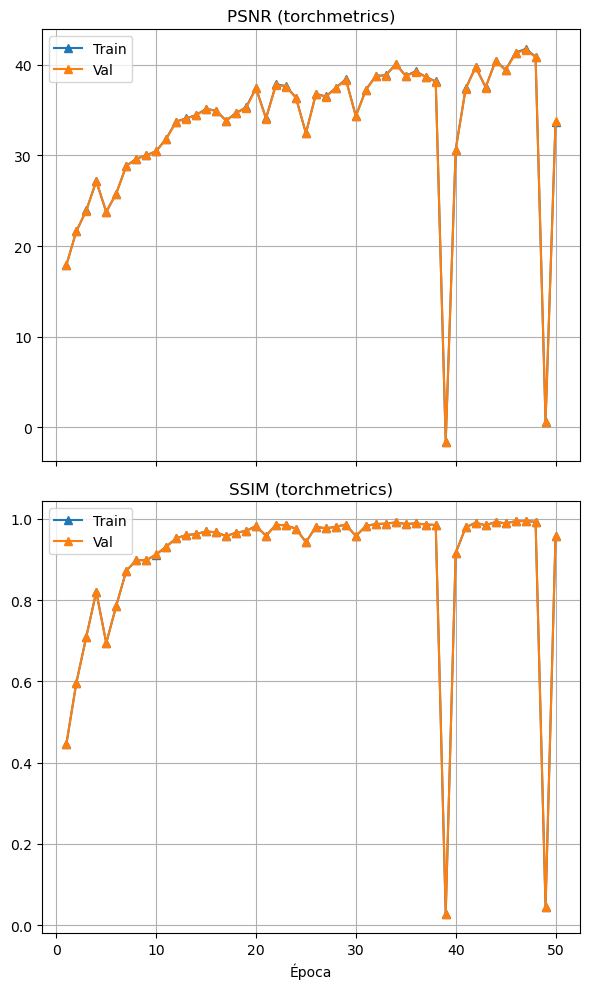

In [7]:
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# 6. Graficar PSNR y SSIM lado a lado
# ──────────────────────────────────────────────────────────────────────────────

# Convertir tensores de GPU a listas de floats en CPU
psnr_tr_vals = [t.cpu().item() for t in trchimg_psnr_tr]
psnr_val_vals = [t.cpu().item() for t in trchimg_psnr_val]
ssim_tr_vals = [t.cpu().item() for t in trchimg_ssim_tr]
ssim_val_vals = [t.cpu().item() for t in trchimg_ssim_val]

fig, axes = plt.subplots(2, 1, figsize=(6, 10), sharex=True)

# --- Fila 0: PSNR ---
ax = axes[0]
ax.plot(epochs, psnr_tr_vals,   label="Train", marker="^")
ax.plot(epochs, psnr_val_vals,  label="Val",   marker="^")
ax.set_title("PSNR (torchmetrics)")
ax.legend()
ax.grid(True)

# --- Fila 1: SSIM ---
ax = axes[1]
ax.plot(epochs, ssim_tr_vals,   label="Train", marker="^")
ax.plot(epochs, ssim_val_vals,  label="Val",   marker="^")
ax.set_title("SSIM (torchmetrics)")
ax.set_xlabel("Época")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

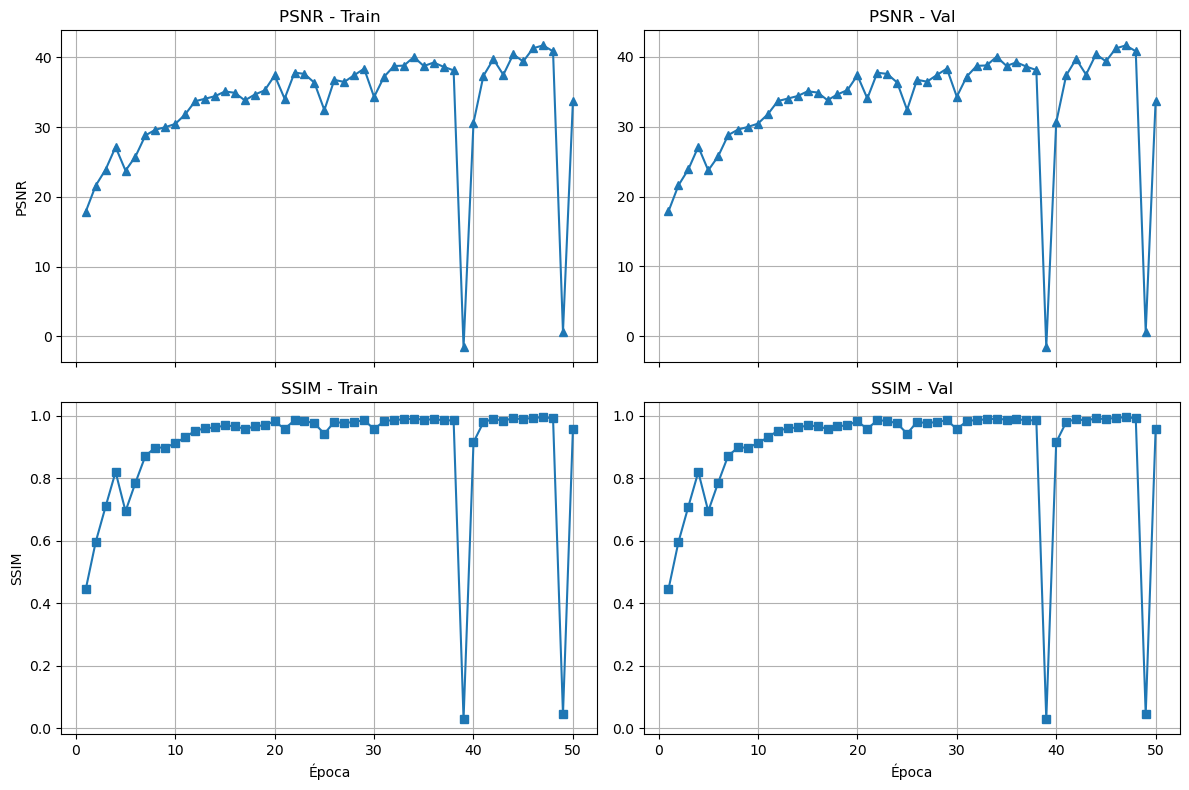

In [8]:
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# 6. Graficar PSNR y SSIM: gráficos separados para Train y Val, lado a lado
# ──────────────────────────────────────────────────────────────────────────────

# Convertir tensores de GPU a listas de floats en CPU
psnr_tr_vals   = [t.cpu().item() for t in trchimg_psnr_tr]
psnr_val_vals  = [t.cpu().item() for t in trchimg_psnr_val]
ssim_tr_vals   = [t.cpu().item() for t in trchimg_ssim_tr]
ssim_val_vals  = [t.cpu().item() for t in trchimg_ssim_val]

# Crear figura con 2 filas (métricas) x 2 columnas (Train vs Val)
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# PSNR Train
ax = axes[0, 0]
ax.plot(epochs, psnr_tr_vals, label="Train PSNR", marker="^")
ax.set_title("PSNR - Train")
ax.set_ylabel("PSNR")
ax.grid(True)

# PSNR Val
ax = axes[0, 1]
ax.plot(epochs, psnr_val_vals, label="Val PSNR", marker="^")
ax.set_title("PSNR - Val")
ax.grid(True)

# SSIM Train
ax = axes[1, 0]
ax.plot(epochs, ssim_tr_vals, label="Train SSIM", marker="s")
ax.set_title("SSIM - Train")
ax.set_ylabel("SSIM")
ax.set_xlabel("Época")
ax.grid(True)

# SSIM Val
ax = axes[1, 1]
ax.plot(epochs, ssim_val_vals, label="Val SSIM", marker="s")
ax.set_title("SSIM - Val")
ax.set_xlabel("Época")
ax.grid(True)

plt.tight_layout()
plt.show()
